# 流れ
- 画像を50x50にダウンサンプリングする必要がある
- 辺の大きい方を基準として50にダウンサンプルし、辺が小さい方の左右を白で補完する
- 白黒にしてからnp.array化する
- 学習済みモデルを読み出して予測する
- 果たしてどうなるの
- ちなみに正解は○度っていうのが無いため、予測結果通りに角度を回転させ、その結果で判断する

In [23]:
import numpy as np
import glob

from PIL import Image
from IPython.display import Image as Image_

In [24]:
#レシートのディレクトリを指定して名前をリスト化する
receipt_dirlist = glob.glob('receipt_photo/*')
receipt_dirlist = [s for s in receipt_dirlist if '_generate' not in s]
receipt_dirlist = [s for s in receipt_dirlist if '_angle_fix' not in s]
receipt_dirlist

['receipt_photo\\IMG_3666.JPG',
 'receipt_photo\\IMG_3667.JPG',
 'receipt_photo\\IMG_3668.JPG',
 'receipt_photo\\IMG_3669.JPG',
 'receipt_photo\\IMG_3670.JPG',
 'receipt_photo\\IMG_3671.JPG',
 'receipt_photo\\IMG_3672.JPG',
 'receipt_photo\\IMG_3673.JPG',
 'receipt_photo\\IMG_3674.JPG',
 'receipt_photo\\IMG_3675.JPG',
 'receipt_photo\\IMG_3676.JPG',
 'receipt_photo\\IMG_3677.JPG',
 'receipt_photo\\IMG_3678.JPG']

In [3]:
#白埋め
def photo_generate(photo_url):
    img = Image.open(photo_url)
    img = img.convert('L') #グレースケール
    #画像が横向きの場合縦にする
    if np.array(img).shape[0] < np.array(img).shape[1]:
        img = img.rotate(-90, expand=True)
    else :
        pass
    
    #画像をダウンサンプル
    img_resize = img.resize((38, 50), Image.LANCZOS)
    
    #50x50の白い画像を作成する
    back_ground = Image.new('L', (50, 50), 255)
    
    #結合する
    back_ground.paste(img_resize, (6, 0))
    
    #保存する
    back_ground.save(f'{photo_url[:-4]}_generate{photo_url[-4:]}')

In [25]:
#黒埋め
def photo_generate(photo_url):
    img = Image.open(photo_url)
    img = img.convert('L') #グレースケール
    #画像が横向きの場合縦にする
    if np.array(img).shape[0] < np.array(img).shape[1]:
        img = img.rotate(-90, expand=True)
    else :
        pass
    
    #画像をダウンサンプル
    img_resize = img.resize((38, 50), Image.LANCZOS)
    
    #50x50の白い画像を作成する
    back_ground = Image.new('L', (50, 50), 0)
    
    #結合する
    back_ground.paste(img_resize, (6, 0))
    
    #保存する
    back_ground.save(f'{photo_url[:-4]}_generate{photo_url[-4:]}')

In [4]:
#埋めなし、はみ出た縦幅カット
def photo_generate(photo_url):
    img = Image.open(photo_url)
    img = img.convert('L') #グレースケール
    #画像が横向きの場合縦にする
    if np.array(img).shape[0] < np.array(img).shape[1]:
        img = img.rotate(-90, expand=True)
    else :
        pass
    
    #画像をダウンサンプル
    img_resize = img.resize((50, 66), Image.LANCZOS)
    
    #縦幅を50まで切り取る
    img_trim = img_resize.crop((0, 8, 50, 58))
    
    #保存する
    img_trim.save(f'{photo_url[:-4]}_generate{photo_url[-4:]}')

In [26]:
#実験でとってきた画像を取得
list(map(lambda x : photo_generate(x), receipt_dirlist))

[None, None, None, None, None, None, None, None, None, None, None, None, None]

## 識別させてみる

In [27]:
#50x50の画像で角度を検出し、その角度だけ、元の画像を回転させる。
#そして、それをVision APIに読ませて、閾値を用いて1行を全部読むようにする
generate_photos = glob.glob('receipt_photo/*')
generate_photos = [s for s in generate_photos if '_generate' in s]

In [28]:
generate_photos

['receipt_photo\\IMG_3666_generate.JPG',
 'receipt_photo\\IMG_3667_generate.JPG',
 'receipt_photo\\IMG_3668_generate.JPG',
 'receipt_photo\\IMG_3669_generate.JPG',
 'receipt_photo\\IMG_3670_generate.JPG',
 'receipt_photo\\IMG_3671_generate.JPG',
 'receipt_photo\\IMG_3672_generate.JPG',
 'receipt_photo\\IMG_3673_generate.JPG',
 'receipt_photo\\IMG_3674_generate.JPG',
 'receipt_photo\\IMG_3675_generate.JPG',
 'receipt_photo\\IMG_3676_generate.JPG',
 'receipt_photo\\IMG_3677_generate.JPG',
 'receipt_photo\\IMG_3678_generate.JPG']

In [29]:
photos_array = []
for url in generate_photos:
    photos_array.append(np.array(Image.open(url)))
    
photos_array = np.array(photos_array)

In [30]:
photos_array[:1]

array([[[0, 0, 2, ..., 0, 0, 0],
        [0, 0, 2, ..., 0, 0, 0],
        [0, 0, 2, ..., 0, 0, 0],
        ...,
        [1, 0, 2, ..., 4, 0, 0],
        [1, 0, 2, ..., 0, 0, 0],
        [1, 0, 2, ..., 0, 0, 0]]], dtype=uint8)

In [31]:
#modelをロードする
import keras
model = keras.models.load_model('receipt_angle_learning.h5')

In [32]:
#値を0~1へ
photos_array_s = photos_array / 255
#予測用の次元へ変更
X_test = photos_array_s.reshape(photos_array_s.shape[0], 50, 50, 1)
#予測
pred = model.predict(X_test)
#予測結果をargmax
pred_classes = np.argmax(pred, axis=1)

In [33]:
pred_classes

array([41, 45, 74, 74, 89, 46, 41, 45, 17, 48, 54, 45, 47], dtype=int64)

In [34]:
#argmaxのclassesは、角度の数値があっていないので戻す
angle_list = np.hstack((np.arange(0, 46), np.arange(-45, 0)))
pred_angles = list(map(lambda x : angle_list[x], pred_classes))

In [35]:
pred_classes

array([41, 45, 74, 74, 89, 46, 41, 45, 17, 48, 54, 45, 47], dtype=int64)

In [36]:
#角度の予測結果
#ぶっちゃけうまく行ってない気がするーーーー
pred_angles

[41, 45, -17, -17, -2, -45, 41, 45, 17, -43, -37, 45, -44]

In [37]:
photos_array[1]

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

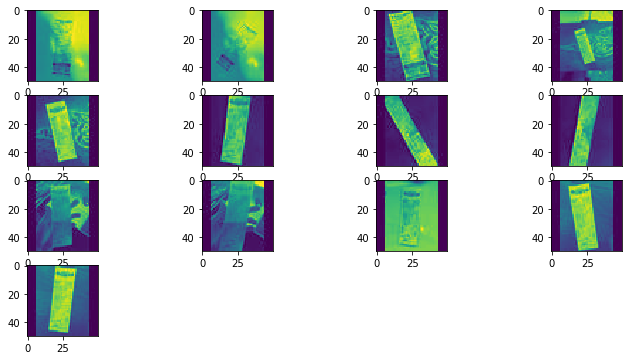

In [38]:
#今更だけど、-は下側が右に寄る+は下側が左に寄る
import matplotlib.pyplot as plt
#画像を並べて見てみる
plt.figure(figsize=(12, 6))
x, y = 4, 4
for i in range(13):
    plt.subplot(y, x, i + 1)
    plt.imshow(photos_array[i].reshape(50, 50), interpolation='nearest')
plt.show()

In [39]:
#結果のとおり画像を傾けてみよう
angle_change = glob.glob('receipt_photo/*')
angle_change = [s for s in receipt_dirlist if '_generate' not in s]
angle_change = [s for s in receipt_dirlist if '_angle_fix' not in s]

In [40]:
print(pred_angles)
print(angle_change)

[41, 45, -17, -17, -2, -45, 41, 45, 17, -43, -37, 45, -44]
['receipt_photo\\IMG_3666.JPG', 'receipt_photo\\IMG_3667.JPG', 'receipt_photo\\IMG_3668.JPG', 'receipt_photo\\IMG_3669.JPG', 'receipt_photo\\IMG_3670.JPG', 'receipt_photo\\IMG_3671.JPG', 'receipt_photo\\IMG_3672.JPG', 'receipt_photo\\IMG_3673.JPG', 'receipt_photo\\IMG_3674.JPG', 'receipt_photo\\IMG_3675.JPG', 'receipt_photo\\IMG_3676.JPG', 'receipt_photo\\IMG_3677.JPG', 'receipt_photo\\IMG_3678.JPG']


In [41]:
#元の解像度の画像を予測どおりの角度ずらす
for i in range(len(pred_angles)):
    img = Image.open(angle_change[i])
    if np.array(img.convert('L')).shape[0] < np.array(img.convert('L')).shape[1]:
        img = img.rotate(-90, expand=True)
    else:
        pass
    
    img = img.rotate(pred_angles[i], expand=True)
    
    img.save(f'{angle_change[i][:-4]}_angle_fix{angle_change[i][-4:]}')

# 一旦結果として
更に角度を良くない方向に曲げているものもある。
学習データをもっと複雑にしたほうが良いかもしれない。
ランダムなノイズを乗せるとか、そういう感じ。

Attension という抽出をやってみるしか無いかもしれない